In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
# torchvision是独立于pytorch的关于图像操作的一些方便工具库。
# torchvision的详细介绍在：https://pypi.org/project/torchvision/0.1.8/
# torchvision主要包括一下几个包：
# vision.datasets : 几个常用视觉数据集，可以下载和加载
# vision.models : 流行的模型，例如 AlexNet, VGG, and ResNet 以及 与训练好的参数。
# vision.transforms : 常用的图像操作，例如：随机切割，旋转等。
# vision.utils : 用于把形似 (3 x H x W) 的张量保存到硬盘中，给一个mini-batch的图像可以产生一个图像格网。

print("PyTorch Version: ",torch.__version__)

PyTorch Version:  1.0.1.post2


首先我们定义一个基于ConvNet的简单神经网络

## 1、加载数据（顺序调整一下）

In [2]:
torch.manual_seed(53113)  #cpu随机种子

#没gpu下面可以忽略
use_cuda = torch.cuda.is_available()  
device = torch.device("cuda" if use_cuda else "cpu")  
batch_size = test_batch_size = 32  
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}


#torch.utils.data.DataLoader在训练模型时使用到此函数，用来把训练数据分成多个batch，
#此函数每次抛出一个batch数据，直至把所有的数据都抛出，也就是个数据迭代器。
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./mnist_data', 
                   train=True, #如果true，从training.pt创建数据集
                   download=True, #如果ture，从网上自动下载
                   
#transform 接受一个图像返回变换后的图像的函数，相当于图像先预处理下
#常用的操作如 ToTensor, RandomCrop，Normalize等. 
#他们可以通过transforms.Compose被组合在一起 
                   transform=transforms.Compose([
                       
                       transforms.ToTensor(), 
#.ToTensor()将shape为(H, W, C)的nump.ndarray或img转为shape为(C, H, W)的tensor，
#其将每一个数值归一化到[0,1]，其归一化方法比较简单，直接除以255即可。
                       
                       transforms.Normalize((0.1307,), (0.3081,)) # 所有图片像素均值和方差
#.Normalize作用就是.ToTensor将输入归一化到(0,1)后，再使用公式”(x-mean)/std”，将每个元素分布到(-1,1)  
                   ])), # 第一个参数dataset：数据集
    batch_size=batch_size, 
    shuffle=True,  #随机打乱数据
    **kwargs)##kwargs是上面gpu的设置
  


test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./mnist_data', 
                   train=False, #如果False，从test.pt创建数据集
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=test_batch_size, 
    shuffle=True, 
    **kwargs)

In [3]:
train_loader.dataset[0][0].shape

torch.Size([1, 28, 28])

# 2、定义CNN模型

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1) 
        #torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1)
        #in_channels：输入图像通道数，手写数字图像为1，彩色图像为3
        #out_channels：输出通道数，这个等于卷积核的数量
        #kernel_size：卷积核大小
        #stride：步长
         
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        #上个卷积网络的out_channels，就是下一个网络的in_channels，所以这里是20
        #out_channels：卷积核数量50
        
        
        self.fc1 = nn.Linear(4*4*50, 500)
        #全连接层torch.nn.Linear(in_features, out_features)
        #in_features:输入特征维度，4*4*50是自己算出来的，跟输入图像维度有关
        #out_features；输出特征维度
        
        self.fc2 = nn.Linear(500, 10)
        #输出维度10，10分类

    def forward(self, x):  
        #print(x.shape)  #手写数字的输入维度，(N,1,28,28), N为batch_size
        x = F.relu(self.conv1(x)) # x = (N,50,24,24)
        x = F.max_pool2d(x, 2, 2) # x = (N,50,12,12)
        x = F.relu(self.conv2(x)) # x = (N,50,8,8)
        x = F.max_pool2d(x, 2, 2) # x = (N,50,4,4)
        x = x.view(-1, 4*4*50)    # x = (N,4*4*50)
        x = F.relu(self.fc1(x))   # x = (N,4*4*50)*(4*4*50, 500)=(N,500)
        x = self.fc2(x)           # x = (N,500)*(500, 10)=(N,10)
        return F.log_softmax(x, dim=1)  #带log的softmax分类，每张图片返回10个概率

# 3、初始化模型和定义优化函数

In [5]:
lr = 0.01
momentum = 0.5
model = Net().to(device) #模型初始化
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum) #定义优化器

NLL loss的定义

$\ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad
        l_n = - w_{y_n} x_{n,y_n}, \quad
        w_{c} = \text{weight}[c] \cdot \mathbb{1}\{c \not= \text{ignore\_index}\}$

# 4、定义训练和测试模型

In [6]:
def train(model, device, train_loader, optimizer, epoch, log_interval=100):
    model.train() #进入训练模式
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad() #梯度归零
        output = model(data)  #输出的维度[N,10] 这里的data是函数的forward参数x
        loss = F.nll_loss(output, target) #这里loss求的是平均数，除以了batch
#F.nll_loss(F.log_softmax(input), target) ：
#单分类交叉熵损失函数，一张图片里只能有一个类别，输入input的需要softmax
#还有一种是多分类损失函数，一张图片有多个类别，输入的input需要sigmoid
        
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:0f}%)]\tLoss: {:.6f}".format(
                epoch, 
                batch_idx * len(data), #100*32
                len(train_loader.dataset), #60000
                100. * batch_idx / len(train_loader), #len(train_loader)=60000/32=1875
                loss.item()
            ))
            #print(len(train_loader))


In [7]:
def test(model, device, test_loader):
    model.eval() #进入测试模式
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data) 
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            #reduction='sum'代表batch的每个元素loss累加求和，默认是mean求平均
                       
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            
            #print(target.shape) #torch.Size([32])
            #print(pred.shape) #torch.Size([32, 1])
            correct += pred.eq(target.view_as(pred)).sum().item()
            #pred和target的维度不一样
            #pred.eq()相等返回1，不相等返回0，返回的tensor维度(32，1)。

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

# 5、查看运行结果

In [8]:
epochs = 2
for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

save_model = True
if (save_model):
    torch.save(model.state_dict(),"mnist_cnn.pt") 
    #词典格式，model.state_dict()只保存模型参数

Train Epoch: 1 [0/60000 (0.000000%)]	Loss: 2.297938
Train Epoch: 1 [3200/60000 (5.333333%)]	Loss: 0.567845
Train Epoch: 1 [6400/60000 (10.666667%)]	Loss: 0.206370
Train Epoch: 1 [9600/60000 (16.000000%)]	Loss: 0.094663
Train Epoch: 1 [12800/60000 (21.333333%)]	Loss: 0.179336
Train Epoch: 1 [16000/60000 (26.666667%)]	Loss: 0.041504
Train Epoch: 1 [19200/60000 (32.000000%)]	Loss: 0.135658
Train Epoch: 1 [22400/60000 (37.333333%)]	Loss: 0.052690
Train Epoch: 1 [25600/60000 (42.666667%)]	Loss: 0.111701
Train Epoch: 1 [28800/60000 (48.000000%)]	Loss: 0.059939
Train Epoch: 1 [32000/60000 (53.333333%)]	Loss: 0.084904
Train Epoch: 1 [35200/60000 (58.666667%)]	Loss: 0.190249
Train Epoch: 1 [38400/60000 (64.000000%)]	Loss: 0.093038
Train Epoch: 1 [41600/60000 (69.333333%)]	Loss: 0.075456
Train Epoch: 1 [44800/60000 (74.666667%)]	Loss: 0.037330
Train Epoch: 1 [48000/60000 (80.000000%)]	Loss: 0.036002
Train Epoch: 1 [51200/60000 (85.333333%)]	Loss: 0.052087
Train Epoch: 1 [54400/60000 (90.666667%)

In [27]:
#同上
torch.manual_seed(53113)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = test_batch_size = 32
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('./fashion_mnist_data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,)) 
                   ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('./fashion_mnist_data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)


lr = 0.01
momentum = 0.5
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

epochs = 2
for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

save_model = True
if (save_model):
    torch.save(model.state_dict(),"fashion_mnist_cnn.pt")

0it [00:00, ?it/s]

100%|█████████▉| 26419200/26421880 [03:45<00:00, 59715.26it/s] 

Extracting ./fashion_mnist_data/FashionMNIST/raw/train-images-idx3-ubyte.gz



0it [00:00, ?it/s]


 56%|█████▌    | 16384/29515 [00:01<00:00, 50281.13it/s]
32768it [00:01, 31038.50it/s]                           
0it [00:00, ?it/s]

Extracting ./fashion_mnist_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz



 43%|████▎     | 1908736/4422102 [00:11<00:36, 68059.49it/s]
26427392it [04:00, 59715.26it/s]                              A
100%|█████████▉| 4415488/4422102 [00:46<00:00, 62264.66it/s]

0it [00:00, ?it/s]

Extracting ./fashion_mnist_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz




  0%|          | 0/5148 [00:00<?, ?it/s]

8192it [00:00, 10963.58it/s]            

Extracting ./fashion_mnist_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!
Train Epoch: 1 [0/60000 (0.000000%)]	Loss: 2.279603
Train Epoch: 1 [3200/60000 (5.333333%)]	Loss: 0.958434
Train Epoch: 1 [6400/60000 (10.666667%)]	Loss: 1.015939
Train Epoch: 1 [9600/60000 (16.000000%)]	Loss: 0.541485



4423680it [01:02, 62264.66it/s]                             

Train Epoch: 1 [12800/60000 (21.333333%)]	Loss: 0.629302
Train Epoch: 1 [16000/60000 (26.666667%)]	Loss: 0.511033
Train Epoch: 1 [19200/60000 (32.000000%)]	Loss: 0.558096
Train Epoch: 1 [22400/60000 (37.333333%)]	Loss: 0.528632
Train Epoch: 1 [25600/60000 (42.666667%)]	Loss: 0.663954
Train Epoch: 1 [28800/60000 (48.000000%)]	Loss: 0.294495
Train Epoch: 1 [32000/60000 (53.333333%)]	Loss: 0.292512
Train Epoch: 1 [35200/60000 (58.666667%)]	Loss: 0.228933
Train Epoch: 1 [38400/60000 (64.000000%)]	Loss: 0.474924
Train Epoch: 1 [41600/60000 (69.333333%)]	Loss: 0.715007
Train Epoch: 1 [44800/60000 (74.666667%)]	Loss: 0.523657
Train Epoch: 1 [48000/60000 (80.000000%)]	Loss: 0.460957
Train Epoch: 1 [51200/60000 (85.333333%)]	Loss: 0.385195
Train Epoch: 1 [54400/60000 (90.666667%)]	Loss: 0.510545
Train Epoch: 1 [57600/60000 (96.000000%)]	Loss: 0.618901

Test set: Average loss: 0.4391, Accuracy: 8396/10000 (84%)

Train Epoch: 2 [0/60000 (0.000000%)]	Loss: 0.385074
Train Epoch: 2 [3200/60000 (5.33

# CNN模型的迁移学习

- 很多时候当我们需要训练一个新的图像分类任务，我们不会完全从一个随机的模型开始训练，而是利用_预训练_的模型来加速训练的过程。我们经常使用在`ImageNet`上的预训练模型。
- 这是一种transfer learning的方法。我们常用以下两种方法做迁移学习。
    - fine tuning: 从一个预训练模型开始，我们改变一些模型的架构，然后继续训练整个模型的参数。
    - feature extraction: 我们不再改变与训练模型的参数，而是只更新我们改变过的部分模型参数。我们之所以叫它feature extraction是因为我们把预训练的CNN模型当做一个特征提取模型，利用提取出来的特征做来完成我们的训练任务。
    
以下是构建和训练迁移学习模型的基本步骤：
- 初始化预训练模型
- 把最后一层的输出层改变成我们想要分的类别总数
- 定义一个optimizer来更新参数
- 模型训练

In [56]:
import numpy as np
import torchvision
from torchvision import datasets, transforms, models

import matplotlib.pyplot as plt
import time
import os
import copy
print("Torchvision Version: ",torchvision.__version__)

Torchvision Version:  0.2.2


数据
------

我们会使用*hymenoptera_data*数据集，[下载](https://download.pytorch.org/tutorial/hymenoptera_data.zip).

这个数据集包括两类图片, **bees** 和 **ants**, 这些数据都被处理成了可以使用`ImageFolder <https://pytorch.org/docs/stable/torchvision/datasets.html#torchvision.datasets.ImageFolder>`来读取的格式。我们只需要把``data_dir``设置成数据的根目录，然后把``model_name``设置成我们想要使用的与训练模型：
::
   [resnet, alexnet, vgg, squeezenet, densenet, inception]

其他的参数有：
- ``num_classes``表示数据集分类的类别数
- ``batch_size``
- ``num_epochs``
- ``feature_extract``表示我们训练的时候使用fine tuning还是feature extraction方法。如果``feature_extract = False``，整个模型都会被同时更新。如果``feature_extract = True``，只有模型的最后一层被更新。

1、查看数据，只是查看作用
---------


In [156]:
# Top level data directory. Here we assume the format of the directory conforms 
#   to the ImageFolder structure
data_dir = "./hymenoptera_data"
# Batch size for training (change depending on how much memory you have)
batch_size = 32


#蜜蜂和蚂蚁数据集不会自动下载，请到群文件下载，并放在当前代码目录下
#os.path.join() 连接路径，相当于.../data_dir/train
all_imgs = datasets.ImageFolder(os.path.join(data_dir, "train"),
                                transforms.Compose([
        transforms.RandomResizedCrop(input_size), #把每张图片变成resnet需要输入的维度224
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]))
loader = torch.utils.data.DataLoader(all_imgs, batch_size=batch_size, shuffle=True, num_workers=4)
#训练数据分batch，变成tensor迭代器

In [157]:
img = next(iter(loader))[0] #这个img是一个batch的tensor

In [158]:
img.shape

torch.Size([32, 3, 224, 224])

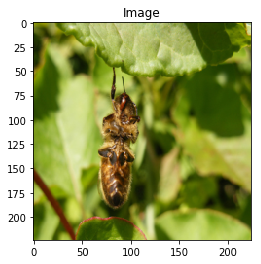

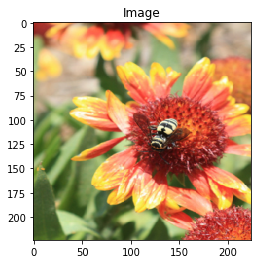

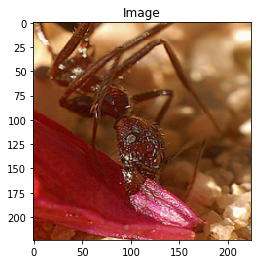

In [159]:
unloader = transforms.ToPILImage()  # reconvert into PIL image
#transforms：torchvision的子模块，常用的图像操作
#.ToPILImage() 把tensor或数组转换成图像
#详细转换过程可以看这个：https://blog.csdn.net/qq_37385726/article/details/81811466

plt.ion() #交互模式，默认是交互模式，可以不写
#详细了解看这个：https://blog.csdn.net/SZuoDao/article/details/52973621
#plt.ioff()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension 
    #这个.squeeze(0)看不懂，去掉也可以运行
    
    image = unloader(image) #tensor转换成图像
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(1) # pause a bit so that plots are updated
    #可以去掉看看，只是延迟显示作用


plt.figure()
imshow(img[8], title='Image') 
imshow(img[9], title='Image')
imshow(img[10], title='Image')

3、把训练集和验证集分batch转换成迭代器
---------

现在我们知道了模型输入的size，我们就可以把数据预处理成相应的格式。


In [160]:
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")


# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}
#把迭代器存放到字典里作为value，key是train和val，后面调用key即可。

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


In [161]:
inputs, labels=next(iter(dataloaders_dict["train"])) #一个batch
print(inputs.shape)
print(labels)

torch.Size([32, 3, 224, 224])
tensor([1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0,
        0, 1, 1, 1, 0, 0, 1, 0])


In [162]:
for inputs, labels in dataloaders_dict["train"]:
    #print(inputs)
    #print(labels)
    print(labels.size()) #最后一个batch不足32

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([20])


## 4、加载resnet模型并修改全连接层

In [193]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"
# Number of classes in the dataset
num_classes = 2
# Number of epochs to train for 
num_epochs = 2
# Flag for feature extracting. When False, we finetune the whole model, 
#   when True we only update the reshaped layer params
feature_extract = True  #只更新修改的层

In [164]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False #提取的参数梯度不更新

In [165]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    if model_name == "resnet":
        model_ft = models.resnet18(pretrained=use_pretrained) 
        #如果True，从imagenet上返回预训练的模型和参数
        
        set_parameter_requires_grad(model_ft, feature_extract)#提取的参数梯度不更新
        #print(model_ft) 可以打印看下
        num_ftrs = model_ft.fc.in_features 
        #model_ft.fc是resnet的最后全连接层
        #(fc): Linear(in_features=512, out_features=1000, bias=True)
        #in_features 是全连接层的输入特征维度
        #print(num_ftrs)
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        #out_features=1000 改为 num_classes=2
        input_size = 224 #resnet18网络输入图片维度是224，resnet34，50，101，152也是
        
    return model_ft, input_size
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

## 5、查看需要更新的参数、定义优化器

In [177]:
next(iter(model_ft.named_parameters()))

('conv1.weight', Parameter containing:
 tensor([[[[-1.0419e-02, -6.1356e-03, -1.8098e-03,  ...,  5.6615e-02,
             1.7083e-02, -1.2694e-02],
           [ 1.1083e-02,  9.5276e-03, -1.0993e-01,  ..., -2.7124e-01,
            -1.2907e-01,  3.7424e-03],
           [-6.9434e-03,  5.9089e-02,  2.9548e-01,  ...,  5.1972e-01,
             2.5632e-01,  6.3573e-02],
           ...,
           [-2.7535e-02,  1.6045e-02,  7.2595e-02,  ..., -3.3285e-01,
            -4.2058e-01, -2.5781e-01],
           [ 3.0613e-02,  4.0960e-02,  6.2850e-02,  ...,  4.1384e-01,
             3.9359e-01,  1.6606e-01],
           [-1.3736e-02, -3.6746e-03, -2.4084e-02,  ..., -1.5070e-01,
            -8.2230e-02, -5.7828e-03]],
 
          [[-1.1397e-02, -2.6619e-02, -3.4641e-02,  ...,  3.2521e-02,
             6.6221e-04, -2.5743e-02],
           [ 4.5687e-02,  3.3603e-02, -1.0453e-01,  ..., -3.1253e-01,
            -1.6051e-01, -1.2826e-03],
           [-8.3730e-04,  9.8420e-02,  4.0210e-01,  ...,  7.0789e-01,


In [178]:
len(next(iter(model_ft.named_parameters()))) #是元组，只有两个值

2

In [179]:
for name,param in model_ft.named_parameters():
    print(name) #看下都有哪些参数

conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.weight
layer2.1.bn2.weight
layer2.1.bn2.bias
layer3.0.conv1.weight
layer3.0.bn1.weight
layer3.0.bn1.bias
layer3.0.conv2.weight
layer3.0.bn2.weight
layer3.0.bn2.bias
layer3.0.downsample.0.weight
layer3.0.downsample.1.weight
layer3.0.downsample.1.bias
layer3.1.conv1.weight
layer3.1.bn1.weight
layer3.1.bn1.bias
layer3.1.conv2.weight
layer3.1.bn2.weight
layer3.1.bn2.bias
layer4.0.conv1.weight
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.conv2.we

In [182]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are 
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters() #需要更新的参数
print("Params to learn:")
if feature_extract:
    params_to_update = [] #需要更新的参数存放在此
    for name,param in model_ft.named_parameters(): 
        #model_ft.named_parameters()有啥看上面cell
        if param.requires_grad == True: 
#这里要知道全连接层之前的层param.requires_grad == Flase
#后面加的全连接层param.requires_grad == True
            params_to_update.append(param)
            print("\t",name)
else: #否则，所有的参数都会更新
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9) #定义优化器
# Setup the loss fxn
criterion = nn.CrossEntropyLoss() #定义损失函数

Params to learn:
	 fc.weight
	 fc.bias


## 6、定义训练模型

In [190]:
#训练测试合一起了
def train_model(model, dataloaders, criterion, optimizer, num_epochs=5):
    since = time.time()
    val_acc_history = [] 
    best_model_wts = copy.deepcopy(model.state_dict())#深拷贝上面resnet模型参数
#.copy和.deepcopy区别看这个：https://blog.csdn.net/u011630575/article/details/78604226 
    best_acc = 0.
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs-1))
        print("-"*10)
        
        for phase in ["train", "val"]:
            running_loss = 0.
            running_corrects = 0.
            if phase == "train":
                model.train()
            else: 
                model.eval()
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                with torch.autograd.set_grad_enabled(phase=="train"):
                    #torch.autograd.set_grad_enabled梯度管理器，可设置为打开或关闭
                    #phase=="train"是True和False，双等号要注意
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    
                _, preds = torch.max(outputs, 1)
                #返回每一行最大的数和索引，prds的位置是索引的位置
                #也可以preds = outputs.argmax(dim=1)
                if phase == "train":
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    
                running_loss += loss.item() * inputs.size(0) #交叉熵损失函数是平均过的
                running_corrects += torch.sum(preds.view(-1) == labels.view(-1)).item()
                #.view(-1)展开到一维，并自己计算
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects / len(dataloaders[phase].dataset)
       
            print("{} Loss: {} Acc: {}".format(phase, epoch_loss, epoch_acc))
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                #模型变好，就拷贝更新后的模型参数
                
            if phase == "val":
                val_acc_history.append(epoch_acc) #记录每个epoch验证集的准确率
            
        print()
    
    time_elapsed = time.time() - since
    print("Training compete in {}m {}s".format(time_elapsed // 60, time_elapsed % 60))
    print("Best val Acc: {}".format(best_acc))
    
    model.load_state_dict(best_model_wts) #把最新的参数复制到model中
    return model, val_acc_history

## 7、运行模型

In [194]:
# Train and evaluate
model_ft, ohist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/1
----------
train Loss: 0.40877683485140565 Acc: 0.8811475409836066
val Loss: 0.3553707284085891 Acc: 0.8954248366013072

Epoch 1/1
----------
train Loss: 0.34885215075289616 Acc: 0.8811475409836066
val Loss: 0.29212033709669427 Acc: 0.9281045751633987

Training compete in 1.0m 33.07470512390137s
Best val Acc: 0.9281045751633987


In [195]:
ohist

[0.8954248366013072, 0.9281045751633987]

In [189]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [196]:
# Initialize the non-pretrained version of the model used for this run
scratch_model,_ = initialize_model(model_name, 
                                   num_classes, 
                                   feature_extract=False, #所有参数都训练
                                   use_pretrained=False)# 不要imagenet的参数
scratch_model = scratch_model.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(), 
                              lr=0.001, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()
_,scratch_hist = train_model(scratch_model, 
                             dataloaders_dict, 
                             scratch_criterion, 
                             scratch_optimizer, 
                             num_epochs=num_epochs)

Epoch 0/1
----------
train Loss: 0.7551555027727221 Acc: 0.47540983606557374
val Loss: 0.7081514643687828 Acc: 0.45098039215686275

Epoch 1/1
----------
train Loss: 0.674949610819582 Acc: 0.5983606557377049
val Loss: 0.6881080678865021 Acc: 0.5359477124183006

Training compete in 3.0m 6.102497100830078s
Best val Acc: 0.5359477124183006


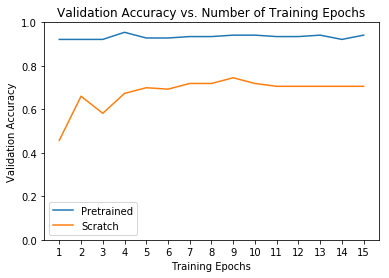

In [134]:

# Plot the training curves of validation accuracy vs. number 
#  of training epochs for the transfer learning method and
#  the model trained from scratch
# ohist = []
# shist = []

# ohist = [h.cpu().numpy() for h in ohist]
# shist = [h.cpu().numpy() for h in scratch_hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.plot(range(1,num_epochs+1),scratch_hist,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()